# Plotting intermidiate network results

In [111]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

This is the repository path:  c:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth
Had to go 0 folder(s) up.


# Load networks

In [112]:
#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

clustered_network = os.getcwd() + '/networks/elec_s_36.nc'
n_cluster = pypsa.Network(clustered_network)

#solved_network = os.getcwd() + "/Result_analysis/buget_only/elec_s_4_ec_lcopt_Co2L-1H.nc"
#solved_network = os.getcwd() + "/Result_analysis/demand_only/elec_s_4_ec_lcopt_Co2L-1H.nc"
#solved_network = os.getcwd() + "/Result_analysis/stand_alone_bau/elec_s_4_ec_lcopt_Co2L-1H.nc"
#solved_network = os.getcwd() + "/Result_analysis/stand_alone_transition/elec_s_4_ec_lcopt_Co2L-1H.nc"
#solved_network = os.getcwd() + "/Result_analysis/coupled_bau/elec_s_4_ec_lcopt_Co2L-1H.nc"
#solved_network = os.getcwd() + "/Result_analysis/coupled_transition/elec_s_36_ec_lcopt_Co2L-1H.nc"

solved_network = os.getcwd() + "/results/networks/elec_s_22_ec_lcopt_Co2L-1H.nc"

#solved_network = r"C:\Users\Carlos\Desktop\PyPSA-BO\pypsa-earth\Result_analysis\GCAM-PyPSA_Scenarios\Red40\elec_s_22_ec_lcopt_Co2L-1H.nc"

n_solve = pypsa.Network(solved_network)

base_network= os.getcwd() +  "/networks/base.nc"
n_base= pypsa.Network(base_network)



c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatibl

In [113]:
n_cluster

PyPSA Network
Components:
 - Bus: 36
 - Carrier: 13
 - Generator: 87
 - Line: 48
 - Load: 36
 - StorageUnit: 8
Snapshots: 8760

In [114]:
n_base

PyPSA Network 'PyPSA-Earth'
Components:
 - Bus: 155
 - Line: 161
 - Transformer: 39
Snapshots: 8760

(<matplotlib.collections.PatchCollection at 0x1b81944c280>,
 <matplotlib.collections.LineCollection at 0x1b81a1abf70>)

c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


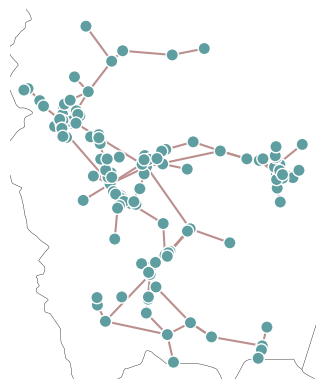

In [115]:
n_base.plot()

In [116]:
n_solve

PyPSA Network
Components:
 - Bus: 66
 - Carrier: 16
 - Generator: 80
 - GlobalConstraint: 1
 - Line: 28
 - Link: 88
 - Load: 22
 - StorageUnit: 6
 - Store: 44
Snapshots: 8760

# Global constraints

In [117]:
##### check why the value does not appear 
#   - It seems that while the model run before, due to restrictions on simulation, proper solving wasn't possible (by increasing tolerances of the solver the model gets actual results)
# Million Eur/Year
n=n_solve
n.objective/1000000

7327.630609986037

In [118]:
n.global_constraints

,sense,constant,mu,type,investment_period,carrier_attribute
GlobalConstraint,,,,,,
CO2Limit,<=,380657.254,355.114144,primary_energy,NaN,co2_emissions


In [119]:
# estimation of the total emissions from the system in MtonCO2:

emissions = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h

#snapshot_weightings provides the number of agregation used for each time step considered (4 hours in this case) and @ ins a multiplier
n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6) # Mt

0.38065646333181186

# Node distribution

C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\1261331503.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


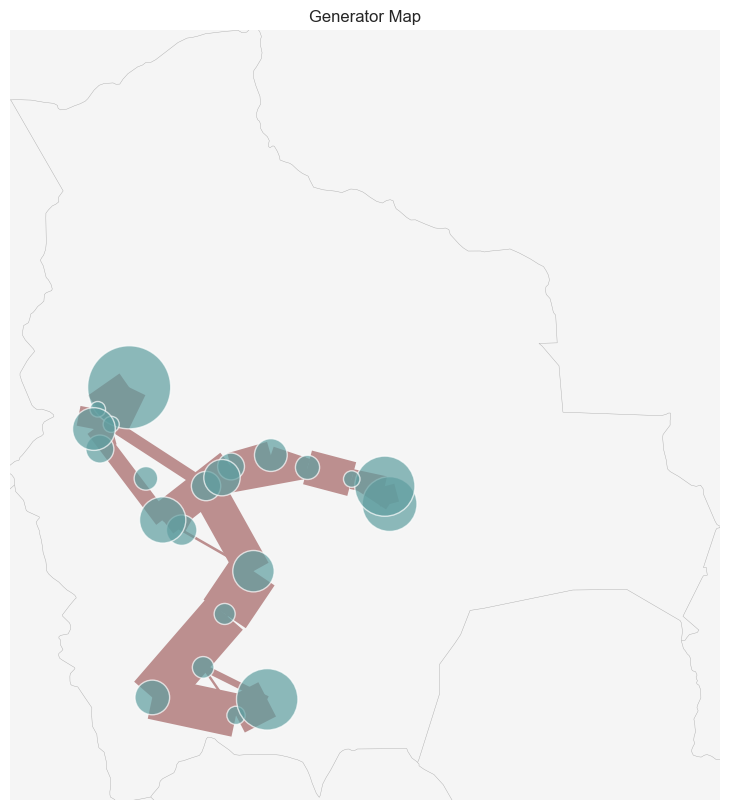

In [120]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=ax,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=0.7,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    )*0.5,  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 1e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


# Generation expansion analysis

In [121]:
# Check generators total capacities nominal (p_nom) optimized (p_nom_opt) 
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,p_nom_extendable,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,marginal_cost_quadratic,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCGT,inf,0.000000,1.236030e+02,4.059459e+05,1.500,123.603,38.667922,BO 10BO 15BO 3,3,,3.818976e+02,3.000,0,0,0,3,0,,0.0,3.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,3.0,3.0
OCGT,inf,0.000000,2.000000e-03,2.275076e+05,0.780,0.002,28.788910,BO 15BO 7,2,,1.108250e+01,2.000,0,0,0,2,0,,0.0,2.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,2.0,2.0
biomass,inf,0.000000,9.900000e+01,2.160893e+05,0.468,99.000,14.967709,BO 10,1,,1.792984e+03,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
geothermal,inf,0.000000,5.500000e+01,3.719135e+05,0.239,55.000,0.009428,BO 4,1,,4.681204e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
load,inf,0.000000,2.200000e+10,0.000000e+00,22.000,0.000,22.220580,BO 0BO 1BO 10BO 11BO 12BO 13BO 14BO 15BO 16BO 17BO 18BO 19BO 2BO 2...,0,PQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQPQ,2.200000e+10,0.022,0,0,0,22,0,,0.0,22.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,22.0,22.0
oil,inf,0.000000,1.000000e-03,3.676253e+04,0.393,0.001,130.236648,BO 0,1,Slack,1.424611e+02,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
onwind,2.375888e+06,160338.106106,4.500000e+01,3.766584e+06,22.000,45.000,0.555358,BO 0BO 1BO 10BO 11BO 12BO 13BO 14BO 15BO 16BO 17BO 18BO 19BO 2BO 2...,22,SlackSlack,4.956002e+01,22.000,0,0,0,22,0,,0.0,22.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,22.0,22.0
ror,inf,321.260000,3.212600e+02,1.083904e+06,5.400,0.000,0.059950,BO 11BO 13BO 14BO 17BO 18BO 8,0,,3.212600e+02,6.000,0,0,0,6,0,,0.0,6.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,6.0,6.0
solar,1.869812e+06,330825.911741,1.004000e+02,1.118831e+06,22.000,100.400,0.439010,BO 0BO 1BO 10BO 11BO 12BO 13BO 14BO 15BO 16BO 17BO 18BO 19BO 2BO 2...,22,,6.154817e+04,22.000,0,0,0,22,0,,0.0,22.0,0.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,22.0,22.0


In [122]:
#installed capacity expansion
generation_expansion = gen_cap['p_nom_opt'] - gen_cap['p_nom']
generation_expansion

carrier
CCGT            258.294614
OCGT             11.080501
biomass        1693.984066
geothermal      413.120396
load              0.000000
oil             142.460068
onwind            4.560024
ror               0.000000
solar         61447.767405
dtype: float64

In [123]:
generation_expansion.sum()

63971.267074898446

# Transmission expansion analysis

In [124]:
alternative_network = os.getcwd() + '/networks/base.nc' #'/networks/elec_s_4.nc' #
n_line = pypsa.Network(alternative_network)
check_lines = n_line.lines
check_lines.s_nom.mean()

c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatibl

196.33884621443696

In [125]:
#Transmission lines 
lines = n.lines
lines

,bus0,bus1,length,carrier,type,s_max_pu,s_nom,capital_cost,num_parallel,s_nom_extendable,s_nom_min,x,r,b,build_year,x_pu_eff,r_pu_eff,s_nom_opt,v_nom,g,s_nom_max,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,BO 0,BO 13,96.789020,AC,Al/St 240/40 4-bundle 380.0,0.7,128.474869,3687.849200,0.075658,True,38.880552,314.707395,38.378951,0.000032,0,0.023796,0.002902,2593.763212,115.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,BO 0,BO 17,88.389240,AC,Al/St 240/40 4-bundle 380.0,0.7,128.474869,3368.397550,0.075658,True,38.880552,287.395693,35.048255,0.000029,0,0.021731,0.002650,2430.495333,115.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,BO 1,BO 10,43.601618,AC,Al/St 240/40 4-bundle 380.0,0.7,1713.914504,1661.643958,1.009312,True,1037.369305,10.627044,1.295981,0.000191,0,0.000201,0.000024,1408.869573,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,BO 1,BO 21,103.892821,AC,Al/St 240/40 4-bundle 380.0,0.7,513.899475,3958.850181,0.302632,True,311.044419,84.451312,10.298940,0.000136,0,0.001596,0.000195,931.148095,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
5,BO 10,BO 21,76.635631,AC,Al/St 240/40 4-bundle 380.0,0.7,642.374343,2920.725908,0.378289,True,388.805524,49.835818,6.077539,0.000126,0,0.000942,0.000115,1447.066027,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
6,BO 11,BO 13,259.590020,AC,Al/St 240/40 4-bundle 380.0,0.7,513.899475,9893.034110,0.302632,True,311.044419,211.012827,25.733272,0.000341,0,0.003989,0.000486,851.608558,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
7,BO 11,BO 14,73.023021,AC,Al/St 240/40 4-bundle 380.0,0.7,1156.273818,2783.122336,0.680921,True,699.849942,26.381418,3.217246,0.000216,0,0.000499,0.000061,2510.257383,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
8,BO 11,BO 15,233.391831,AC,Al/St 240/40 4-bundle 380.0,0.7,513.899475,8891.036750,0.302632,True,311.044419,189.717116,23.136234,0.000306,0,0.003586,0.000437,1594.968659,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
9,BO 11,BO 2,41.114128,AC,Al/St 240/40 4-bundle 380.0,0.7,128.474869,1566.931727,0.075658,True,77.761105,133.681693,16.302645,0.000013,0,0.002527,0.000308,715.709492,230.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [126]:
lines.s_nom

Line
1      128.474869
2      128.474869
3     1713.914504
4      513.899475
5      642.374343
6      513.899475
7     1156.273818
8      513.899475
9      128.474869
10     128.474869
11     513.899475
12     642.374343
13     642.374343
14      43.741211
15     513.899475
16    1156.273818
17     128.474869
18     513.899475
19    1027.798949
20     513.899475
21     385.424606
22     513.899475
23     814.590423
24     513.899475
25     513.899475
26     128.474869
27     172.216080
28     513.899475
Name: s_nom, dtype: float64

In [127]:
lines.s_nom.sum()

14821.099870639424

In [128]:
lines.s_nom.mean()

529.3249953799794

In [129]:
#transmission capacity expansion
transmission_expansion = lines['s_nom_opt'] - lines['s_nom']
transmission_expansion

Line
1     2465.288343
2     2302.020464
3     -305.044931
4      417.248620
5      804.691684
6      337.709083
7     1353.983565
8     1081.069184
9      587.234624
10     420.299368
11    1973.544463
12    1833.975435
13    -103.462771
14     128.637871
15     -32.902249
16    1832.793469
17     163.037129
18    1465.573714
19    1479.589958
20     752.960798
21    2146.120393
22    2946.159308
23    2852.522041
24    2262.674478
25    2618.767687
26      56.398662
27     -40.068507
28     652.206042
dtype: float64

In [130]:
real_expansion = 0
for i in range(len(transmission_expansion)):  # Iterate over the indices of the Series
    if transmission_expansion.iloc[i] > 0:  # Check if the expansion value is greater than 0
        real_expansion += transmission_expansion.iloc[i]  # Add the expansion value to real_expansion

print("Total expansion of the system:", real_expansion)

Total expansion of the system: 32934.50638324794


In [131]:
max_line_expansion = transmission_expansion.max()
max_line_expansion

2946.1593076821646

In [132]:
load_shedding = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()["load"]
load_shedding.sum()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\4069741317.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  load_shedding = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()["load"]


11781849.659373276

C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3318148257.py:165: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3318148257.py:175: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


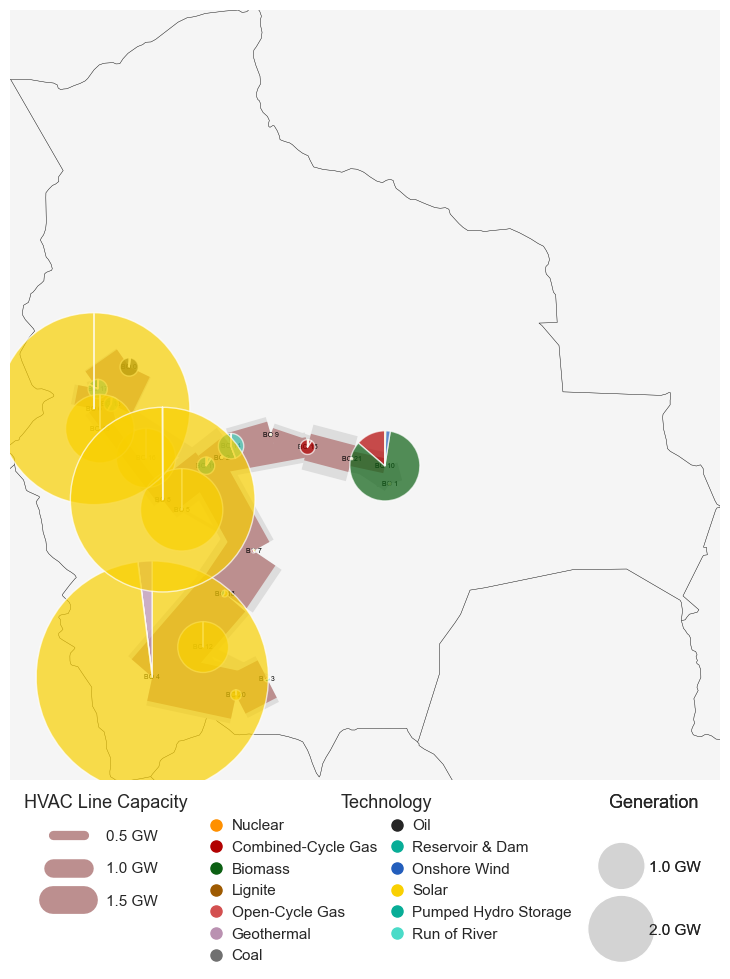

In [133]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.5, 1.0, 1.5):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=1.2,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")

    # Filter n.carriers to only exclude "H2" and "batteries"
    filtered_carriers = n.carriers.loc[~n.carriers.index.isin(['H2', 'battery'])]

    # Iterate over the filtered carriers
    for name, carrier in filtered_carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )

        labels.append(carrier.nice_name)
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [10, 20]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GW" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=3.2,
        title="Generation",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 6.0e3
    branch_factor = 7.5e1

    fields = ["bus", "carrier", "p_nom","p_nom_opt"]
        
    pie_components = pd.concat(
        [
            n.generators.loc[n.generators.carrier != "load", fields],
            n.storage_units[fields],
        ]
    )
    bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor

    def clip(df, thres=500):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )


    # Convert "Bus" index column to string type
    filtered_buses = n.buses
    filtered_buses.index = filtered_buses.index.astype(str)
    filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    
    # Add bus names to the plot
    for bus, (lon, lat) in filtered_buses[['x', 'y']].iterrows():
        ax.text(lon, lat, bus, fontsize=5, color='black', ha='center', va='center')


    add_legend(ax, bus_factor, branch_factor)

    ### section added to define the national border
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    shapes=world[world.name.isin(["Bolivia"])].set_index("name")
    ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")


plot_network(n)

In [134]:
#plot_network(n,r"C:\Users\Carlos\Desktop\generation.eps")

# Operational parameters

In [135]:
n.objective/1000000

7327.630609986037

In [136]:
n.statistics()

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                9.219304e-01         3.874447e+08   
            Combined-Cycle Gas     1.058322e-01         5.167659e+07   
            Geothermal             5.017249e-01         1.741003e+08   
            Oil                    2.718861e-02         5.237229e+06   
            Onshore Wind           1.008389e-01         8.485090e+06   
            Open-Cycle Gas         6.459655e-02         1.260677e+06   
            Run of River           6.059069e-01         5.803582e+07   
            Solar                  2.004971e-01         3.130091e+09   
            load                   6.113455e-08         0.000000e+00   
Line        AC                     4.898768e-01         2.267722e+08   
Link        H2 electrolysis        3.041190e-01         3.397264e+08   
            H2 fuel cell           3.364353e-01         1.231444e+08   
            battery charger        2.832360e-01         7.343643e+08   
            battery discharger     2.294211e-01         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam        3.698285e-01         0.000000e+00   
Store       Battery Storage        4.661866e-01         1.855720e+09   
            Hydrogen Storage       4.971413e-01         1.873193e+08   

                                 Curtailment      Dispatch  \
            carrier                                          
Generator   Biomass             0.000000e+00  1.448034e+07   
            Combined-Cycle Gas  0.000000e+00  3.540536e+05   
            Geothermal          0.000000e+00  2.057441e+06   
            Oil                 0.000000e+00  3.393027e+04   
            Onshore Wind        2.297608e+03  4.377878e+04   
            Open-Cycle Gas      0.000000e+00  6.271208e+03   
            Run of River        1.017952e+05  1.705166e+06   
            Solar               4.765472e+06  1.081004e+08   
            load                0.000000e+00  1.178185e+04   
Line        AC                           NaN  5.467164e+07   
Link        H2 electrolysis              NaN -1.854842e+07   
            H2 fuel cell                 NaN -1.483874e+07   
            battery charger              NaN -4.731690e+07   
            battery discharger           NaN -4.258521e+07   
Load        -                            NaN -1.090101e+08   
StorageUnit Reservoir & Dam     0.000000e+00  1.149088e+06   
Store       Battery Storage              NaN -1.886136e-11   
            Hydrogen Storage             NaN -9.023893e-11   

                                Installed Capacity  Market Value  \
            carrier                                                
Generator   Biomass                   9.900000e+01  8.437156e+01   
            Combined-Cycle Gas        1.236030e+02  2.906801e+02   
            Geothermal                5.500000e+01  1.232503e+02   
            Oil                       1.000000e-03  5.078910e+02   
            Onshore Wind              4.500000e+01  6.734874e+01   
            Open-Cycle Gas            2.000000e-03  3.773610e+02   
            Run of River              3.212600e+02  7.752094e+01   
            Solar                     1.004000e+02  2.897056e+01   
            load                      2.200000e+10  9.840453e+05   
Line        AC                        1.482110e+04  4.139808e+00   
Link        H2 electrolysis           0.000000e+00 -1.828301e+01   
            H2 fuel cell              0.000000e+00 -8.260055e+00   
            battery charger           0.000000e+00 -1.547494e+01   
            battery discharger        0.000000e+00 -2.243983e-02   
Load        -                                  NaN -7.800271e+01   
StorageUnit Reservoir & Dam           3.546900e+02  1.421743e+02   
Store       Battery Storage           0.000000e+00 -1.221346e+20   
            Hydrogen Storage          0.000000e+00 -4.2932

In [137]:
# Capital expenditure for optimized values (annual values based on p_nom_opt) [Eur/year]
n.statistics.capex().sum()

7283378187.936634

In [138]:
# Capital expenditure (annual values based on p_nom_opt) [Eur/year]
n.statistics.opex(aggregate_time="sum").sum()

239895909.80942383

In [139]:
#manual sum of components to obtain capex of the system [Million Eur/year]
capex = (n.generators.p_nom_opt * n.generators.capital_cost).div(1e6).sum()  + (n.storage_units.p_nom_opt * n.storage_units.capital_cost).div(1e6).sum() + (n.lines.s_nom_opt * n.lines.capital_cost).div(1e6).sum() + (n.stores.e_nom_opt * n.stores.capital_cost).div(1e6).sum()# M€/a
capex

6086.143006949256

In [140]:
#manual sum of components to obatin opex of the system [Million Eur/year]
opex = (n.snapshot_weightings.generators @ n.generators_t.p * (n.generators.marginal_cost).div(1e6)).sum() + (n.snapshot_weightings.generators @ n.storage_units_t.p * (n.storage_units.marginal_cost).div(1e6)).sum()  # M€/a
opex

239.89590980942373

In [141]:
#manual sum of components to obtain capex of only the expanded capacity (p_nom_opt-p_nom) [Million Eur/year]
capex2 = ((n.generators.p_nom_opt - n.generators.p_nom)* n.generators.capital_cost).div(1e6).sum()  + ((n.storage_units.p_nom_opt - n.storage_units.p_nom ) * n.storage_units.capital_cost).div(1e6).sum() + ((n.lines.s_nom_opt - n.lines.s_nom) * n.lines.capital_cost).div(1e6).sum() + ((n.stores.e_nom_opt - n.stores.e_nom) * n.stores.capital_cost).div(1e6).sum()# M€/a
capex2

5890.4995009684

# Expansion and generation charts 

C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\437100673.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")


<AxesSubplot:xlabel='snapshot'>

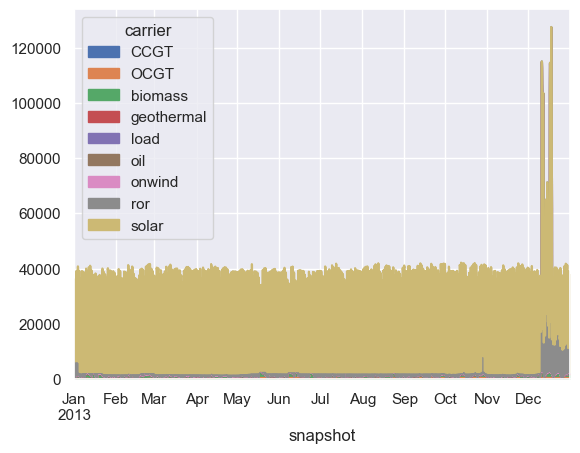

In [142]:
n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")

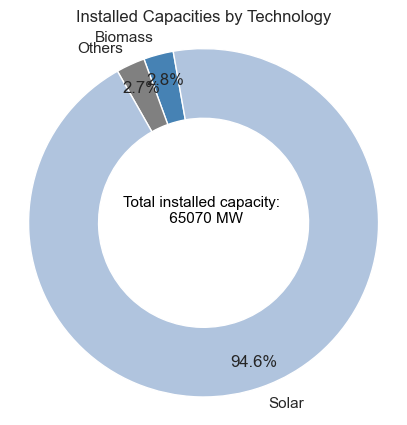

In [143]:
#selecting generation capacities from statistics
capacities = pd.DataFrame(n.statistics.optimal_capacity())
capacities = capacities.drop(index=['Line','Load','Link','Store'], level=0)
capacities = capacities.reset_index(level=0, drop=True)
capacities.rename(columns={0:"MW"}, inplace=True)
capacities.index.name = "Technology"
capacities = capacities.drop(index=['load'])
capacities['Percentage'] = capacities['MW']/capacities['MW'].sum()*100

#defining colors for each technology
OCGT_color='lightcoral'
CCGT_color='indianred'
Onwind_color='#ff8200'
Solar_color='gold'
ror_color='lightsteelblue'
reservoir_color='steelblue'
H2_color='darkgoldenrod'
battery_color='tan'
oil_color='grey'
biomass_color='#73A917'
demand_color='slategrey'
geothermal_color = 'purple'
capacities['Color'] = [reservoir_color, biomass_color, CCGT_color, geothermal_color, oil_color, Onwind_color, OCGT_color, ror_color, Solar_color]


# Identify, adding and removing capacities smaller than 1%
small_capacities = capacities[capacities['Percentage'] < 2]
capacities.loc['Others'] = [small_capacities['MW'].sum(), small_capacities['Percentage'].sum(), small_capacities.loc['Onshore Wind','Color']]
capacities = capacities.drop(index=small_capacities.index)
capacities = capacities.sort_index()

#plotting the results

plt.figure(figsize=(5, 5))
plt.pie(capacities['MW'], labels=capacities.index, colors=capacities['Color'], autopct='%1.1f%%', startangle=100, pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Calculate total installed capacities
total_capacity = capacities['MW'].sum()

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total installed capacity: \n {int(total_capacity)} MW', fontsize=11, color='black', ha='center')
plt.title('Installed Capacities by Technology')
plt.show()

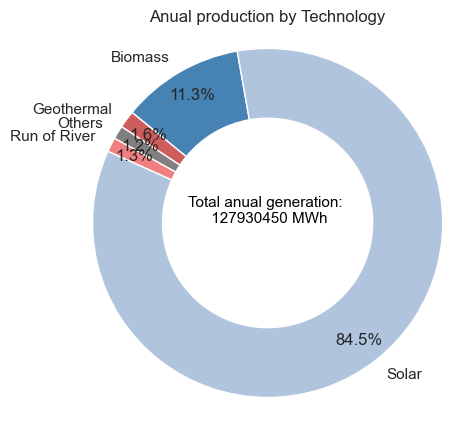

In [144]:
#selecting production from statistics
production = pd.DataFrame(n.statistics.dispatch())
production = production.drop(index=['Line','Load','Link','Store'], level=0)
production = production.reset_index(level=0, drop=True)
production.rename(columns={0:"MWh"}, inplace=True)
production.index.name = "Technology"
production = production.drop(index=['load'])
production['Percentage'] = production['MWh']/production['MWh'].sum()*100

#defining colors for each technology
OCGT_color='lightcoral'
CCGT_color='indianred'
Onwind_color='#ff8200'
Solar_color='gold'
ror_color='lightsteelblue'
reservoir_color='steelblue'
H2_color='darkgoldenrod'
battery_color='tan'
oil_color='grey'
biomass_color='#73A917'
demand_color='slategrey'
geothermal_color = 'purple'
production['Color'] = [reservoir_color, biomass_color, CCGT_color, geothermal_color, oil_color, Onwind_color, OCGT_color, ror_color, Solar_color]


# Identify, adding and removing capacities smaller than 1%
small_production = production[production['Percentage'] < 1]
production.loc['Others'] = [small_production['MWh'].sum(), small_production['Percentage'].sum(), small_production.loc['Onshore Wind','Color']]
production = production.drop(index=small_production.index)
production = production.sort_index()

#plotting the results

plt.figure(figsize=(5, 5))
plt.pie(production['MWh'], labels=production.index, colors=production['Color'], autopct='%1.1f%%', startangle=100, pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Calculate total installed capacities
total_production = production['MWh'].sum()

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total anual generation: \n {int(total_production)} MWh', fontsize=11, color='black', ha='center')
plt.title('Anual production by Technology')
plt.show()

In [145]:
storage_capacities = pd.DataFrame(n.statistics.optimal_capacity())
storage_capacities = storage_capacities.drop(index=['Line','Generator','StorageUnit'], level=0)
storage_capacities

0
      carrier                          
Store Battery Storage     116874.522184
      Hydrogen Storage    235241.985012
Link  H2 electrolysis       6962.404868
      H2 fuel cell          5034.904814
      battery charger      19070.574144
      battery discharger   21189.526826

C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3044627572.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]*time_aggregation
C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3044627572.py:8: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]*time_aggregation
C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3044627572.py:9: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]*time_aggregation
C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3044627572.py:10: FutureWarning: DataFrame.gro

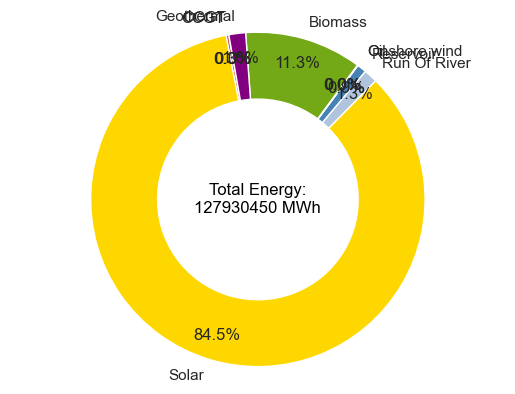

In [146]:

import matplotlib.pyplot as plt
first_date = "2013-01-01"
second_date = "2014-01-01"

time_aggregation = 1   #number hour hours considered by snapshot

OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]*time_aggregation
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]*time_aggregation
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]*time_aggregation
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]*time_aggregation


size = OCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]*time_aggregation
else:
    ror = np.zeros(size)
    
if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]*time_aggregation
else:
    biomass = np.zeros(size)
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]*time_aggregation
else:
    CCGT = np.zeros(size)

if "H2" in n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]*time_aggregation
else:
    H2 = np.zeros(size)
    
if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]*time_aggregation
else:
    battery = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)*time_aggregation
else:
    reservoir = np.zeros(size)

if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)


# Original data
labels = ['OCGT', 'CCGT', 'Solar', 'Run Of River', 'Reservoir', 'Onshore wind', 'Oil', 'Biomass', 'Geothermal']
sizes = [OCGT.sum(), CCGT.sum(), solar.sum(), ror.sum(), reservoir.sum(),Onwind.sum(), oil.sum(), biomass.sum(), geothermal.sum()]
colors = [OCGT_color, CCGT_color, Solar_color, ror_color, reservoir_color,Onwind_color, oil_color, biomass_color, geothermal_color]

# Filter data based on size > 0.5
filtered_labels = []
filtered_sizes = []
filtered_colors = []

for label, size, color in zip(labels, sizes, colors):
    if size > 10:
        filtered_labels.append(label)
        filtered_sizes.append(size)
        filtered_colors.append(color)

# Calculate the total sum of energy production
total_production = sum(filtered_sizes)

# Function to format the label text with actual values
def format_label(value):
    int_value = int(value)
    return str(int_value)

# Generate the pie chart
plt.pie(filtered_sizes, labels=filtered_labels, colors=filtered_colors, autopct='%1.1f%%', startangle=100, pctdistance=0.85, wedgeprops={'width': 0.4})
plt.axis('equal')

# Add the total energy annotation at the center of the pie chart
plt.text(0, 0, f'Total Energy:\n{int(total_production)} MWh', fontsize=12, color='black', ha='center', va='center')

#plt.savefig('energy_pie_run4.eps', format=image_format, dpi=1200)
plt.show()


C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\1650425330.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).mean().plot(kind = "area")


<AxesSubplot:xlabel='snapshot'>

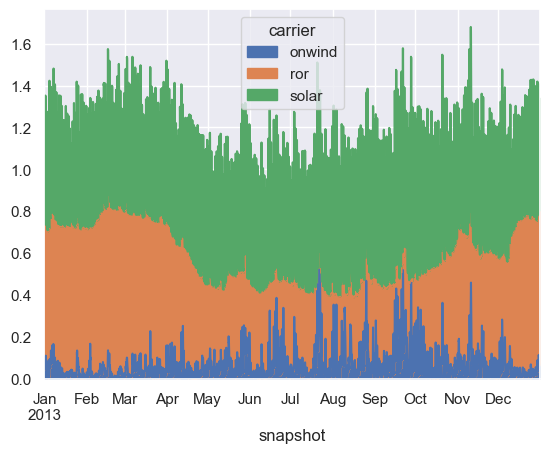

In [147]:
n.generators_t.p_max_pu.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).mean().plot(kind = "area")

C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3559581252.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  capacity_factor = n.generators_t.p_max_pu.loc["2013-01-01":"2013-01-07"].groupby(n.generators.carrier, axis=1).mean()


<AxesSubplot:xlabel='snapshot'>

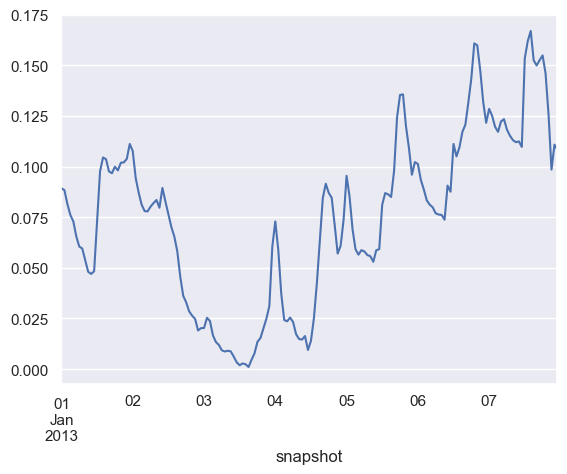

In [148]:
capacity_factor = n.generators_t.p_max_pu.loc["2013-01-01":"2013-01-07"].groupby(n.generators.carrier, axis=1).mean()
capacity_factor['onwind'].plot()

# Curtailment chart

In [149]:
#energy generated by type of powerplant
production_cap = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()
production_cap.sum()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\2440099205.py:2: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  production_cap = n.generators_t.p.loc["2013-01-01":"2014-01-01"].groupby(n.generators.carrier, axis=1).sum()


carrier
CCGT          3.540536e+05
OCGT          6.271208e+03
biomass       1.448034e+07
geothermal    2.057441e+06
load          1.178185e+07
oil           3.393027e+04
onwind        4.377878e+04
ror           1.705166e+06
solar         1.081004e+08
dtype: float64

In [150]:
test = n.generators.loc[[idx for idx in n.generators.index if 'solar' in idx]]
test

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,carrier,p_nom_extendable,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,marginal_cost_quadratic,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 solar,392494.249171,54076.967278,0.0,50855.958267,1.0,0.0,0.020608,BO 0,solar,True,,1.911190,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,83479.300332,11669.887808,0.0,50855.958267,1.0,0.0,0.019593,BO 1,solar,True,,4.124885,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 10 solar,129597.065559,18274.410357,0.0,50855.958267,1.0,0.0,0.019209,BO 10,solar,True,,7.673160,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 11 solar,18936.695940,3378.581885,0.0,50855.958267,1.0,0.0,0.020236,BO 11,solar,True,,4.480434,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 12 solar,92168.507437,19433.587345,0.0,50855.958267,1.0,0.0,0.019232,BO 12,solar,True,,1122.828003,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 13 solar,7351.111130,1174.340972,0.0,50855.958267,1.0,0.0,0.019712,BO 13,solar,True,,1.785445,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 14 solar,943.517546,146.201969,0.0,50855.958267,1.0,0.0,0.020667,BO 14,solar,True,,1.167202,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 15 solar,5670.706582,772.980972,0.0,50855.958267,1.0,0.0,0.019528,BO 15,solar,True,,1.785252,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 16 solar,30184.047385,5672.150536,0.0,50855.958267,1.0,0.0,0.019478,BO 16,solar,True,,1528.532138,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [151]:
test2 = n.generators_t.p_max_pu.filter(regex='solar')
test2

Generator,BO 0 solar,BO 1 solar,BO 10 solar,BO 11 solar,BO 12 solar,BO 13 solar,BO 14 solar,BO 15 solar,BO 16 solar,BO 17 solar,BO 18 solar,BO 19 solar,BO 2 solar,BO 20 solar,BO 21 solar,BO 3 solar,BO 4 solar,BO 5 solar,BO 6 solar,BO 7 solar,BO 8 solar,BO 9 solar
snapshot,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.374904,0.417756,0.395148,0.351523,0.455002,0.287467,0.300276,0.398193,0.350086,0.263927,0.492411,0.504005,0.448621,0.373465,0.395908,0.433832,0.520043,0.381208,0.459434,0.416556,0.483841,0.317031
2013-12-31 20:00:00,0.337530,0.373761,0.352324,0.347772,0.370155,0.172268,0.237071,0.358022,0.255663,0.140531,0.353420,0.321647,0.340506,0.231183,0.364170,0.328761,0.391445,0.314944,0.302331,0.337051,0.362174,0.350285
2013-12-31 21:00:00,0.230257,0.225880,0.204624,0.227149,0.175879,0.089131,0.202429,0.224558,0.154500,0.100192,0.234051,0.192391,0.257568,0.163978,0.219445,0.182509,0.279198,0.206144,0.193380,0.219365,0.233815,0.200548


In [152]:
test3 = test2*test['p_nom_opt']
test3

Generator,BO 0 solar,BO 1 solar,BO 10 solar,BO 11 solar,BO 12 solar,BO 13 solar,BO 14 solar,BO 15 solar,BO 16 solar,BO 17 solar,BO 18 solar,BO 19 solar,BO 2 solar,BO 20 solar,BO 21 solar,BO 3 solar,BO 4 solar,BO 5 solar,BO 6 solar,BO 7 solar,BO 8 solar,BO 9 solar
snapshot,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 02:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 04:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 19:00:00,0.716513,1.723195,3.032035,1.574976,510.889496,0.513256,0.350483,0.710876,535.117079,0.548631,5.770388,1028.830017,1.300985,17.544827,0.554790,0.762605,11958.319019,1122.801030,7353.647674,1.014332,7168.449318,0.470025
2013-12-31 20:00:00,0.645083,1.541721,2.703437,1.558170,415.620344,0.307576,0.276709,0.639159,390.789739,0.292125,4.141594,656.581328,0.987457,10.860639,0.510316,0.577909,9001.212063,927.628966,4839.079921,0.820732,5365.858801,0.519327
2013-12-31 21:00:00,0.440066,0.931729,1.570111,1.017726,197.481868,0.159139,0.236275,0.400892,236.158810,0.208271,2.742753,392.728408,0.746938,7.703452,0.307510,0.320821,6420.118067,607.172120,3095.215414,0.534162,3464.138658,0.297329


C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\628871252.py:7: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]


<AxesSubplot:xlabel='snapshot'>

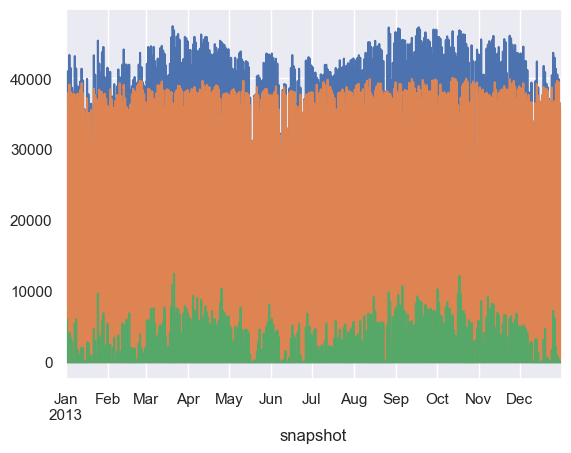

In [153]:
n = n_solve
first_date = "2013-01-01"
second_date = "2014-01-01"

maximum_solar_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='solar') * n.generators.loc[[idx for idx in n.generators.index if 'solar' in idx]]['p_nom_opt']
maximum_solar_generation = maximum_solar_generation.sum(axis=1)
solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
curtailment_solar = maximum_solar_generation - solar_generation


maximum_solar_generation.plot()
solar_generation.plot()
curtailment_solar.plot()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3601894260.py:14: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3601894260.py:19: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3601894260.py:20: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3601894260.py:21: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `f

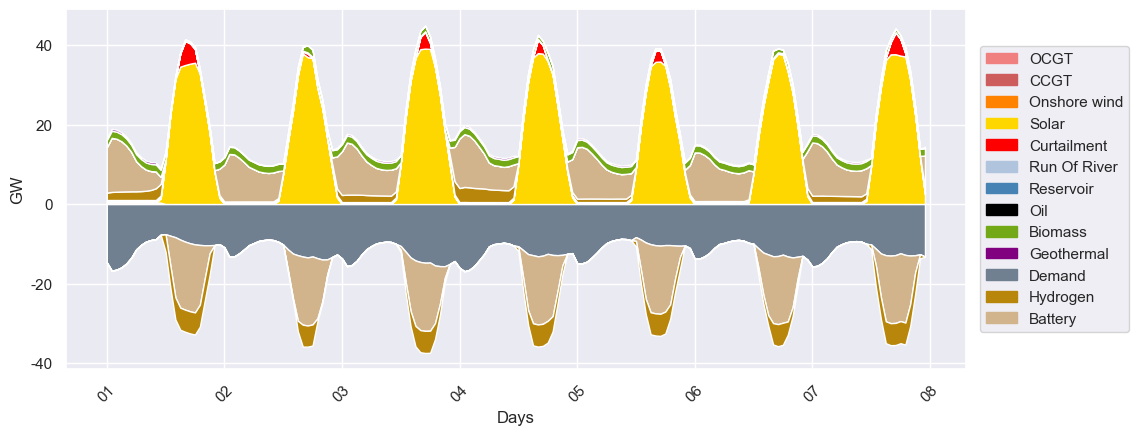

                   p_nom     p_nom_opt
carrier                               
CCGT        1.236030e+02  3.818976e+02
OCGT        2.000000e-03  1.108250e+01
biomass     9.900000e+01  1.792984e+03
geothermal  5.500000e+01  4.681204e+02
load        2.200000e+10  2.200000e+10
oil         1.000000e-03  1.424611e+02
onwind      4.500000e+01  4.956002e+01
ror         3.212600e+02  3.212600e+02
solar       1.004000e+02  6.154817e+04

hydro storage : p_nom: 354.69  p_nom_opt: 354.69
                    p_nom     p_nom_opt
carrier                                
H2 electrolysis       0.0   6962.404868
H2 fuel cell          0.0   5034.904814
battery charger       0.0  19070.574144
battery discharger    0.0  21189.526826


In [154]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

n = n_solve
first_date = "2013-01-01"
second_date = "2013-01-07"

#Hourly curtailment calculation
maximum_solar_generation = n.generators_t.p_max_pu.loc[first_date:second_date].filter(regex='solar') * n.generators.loc[[idx for idx in n.generators.index if 'solar' in idx]]['p_nom_opt']
maximum_solar_generation = maximum_solar_generation.sum(axis=1)
solar_generation = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
curtailment_solar = maximum_solar_generation - solar_generation
curtailment = curtailment_solar.loc[first_date:second_date]

#Hourly generation per technology
OCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["OCGT"]
Onwind = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["onwind"]
solar = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["solar"]
oil = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["oil"]

#Hourly load/demand 
demand = n.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1

size = OCGT.shape[0]

if "ror" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    ror = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["ror"]
else:
    ror = np.zeros(size)
    
if "biomass" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    biomass = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["biomass"]
else:
    biomass = np.zeros(size)
    
if "CCGT" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    CCGT = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["CCGT"]
else:
    CCGT = np.zeros(size)

if "H2" in n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    H2 = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["H2"]
else:
    H2 = np.zeros(size)
    
if "battery" in  n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum().columns:
    battery = n.stores_t.p.loc[first_date:second_date].groupby(n.stores.carrier, axis=1).sum()["battery"]
else:
    battery = np.zeros(size)

if not n.storage_units_t.p.loc[first_date:second_date].sum(axis=1).empty:
    reservoir = n.storage_units_t.p.loc[first_date:second_date].sum(axis=1)
else:
    reservoir = np.zeros(size)
    
if "geothermal" in n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum().columns:
    geothermal = n.generators_t.p.loc[first_date:second_date].groupby(n.generators.carrier, axis=1).sum()["geothermal"]
else:
    geothermal = np.zeros(size)

#Hourly storage charge or discharge 
i=0
nbattery = []
pbattery =[]
for i in battery:
    if i < 0:
        nbattery.append(i)
    else:
        nbattery.append(0) 
for i in battery:
    if i > 0:
        pbattery.append(i)
    else:
        pbattery.append(0) 

i=0
nH2 = []
pH2=[]
for i in H2:
    if i < 0:
        nH2.append(i)
    else:
        nH2.append(0) 
for i in H2:
    if i > 0:
        pH2.append(i)
    else:
        pH2.append(0) 

# create a figure with a single subplot
fig, ax = plt.subplots(figsize=(12, 4))

# adjust the position of the subplot so that it only takes up 2/3 of the available space
ax.set_position([0.1, 0.1, 0.75, 0.9])

OCGT_color='lightcoral'
CCGT_color='indianred'
Onwind_color='#ff8200'
Solar_color='gold'
curtailment_color = 'red'
ror_color='lightsteelblue'
reservoir_color='steelblue'
H2_color='darkgoldenrod'
battery_color='tan'
oil_color='black'
biomass_color='#73A917'
demand_color='slategrey'
geothermal_color = 'purple'

A = plt.stackplot(OCGT.index, OCGT, CCGT, Onwind, solar, curtailment, ror,reservoir, pH2, pbattery, oil, biomass, geothermal,
colors=[OCGT_color,CCGT_color,Onwind_color,Solar_color,curtailment_color,ror_color,reservoir_color,H2_color,battery_color,oil_color,biomass_color,geothermal_color], zorder = 3)
plt.stackplot(OCGT.index,demand,nbattery,nH2, colors=[demand_color,battery_color,H2_color], zorder = 3)
plt.xticks(rotation = 45)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('GW')
ax.set_xlabel('Days')

OCGT_patch = mpatches.Patch(color=OCGT_color, label ='OCGT')
CCGT_patch = mpatches.Patch(color=CCGT_color, label ='CCGT')
wind_patch = mpatches.Patch(color=Onwind_color, label ='Onshore wind')
solar_patch = mpatches.Patch(color=Solar_color, label ='Solar')
curtailment_patch = mpatches.Patch(color=curtailment_color, label = 'Curtailment')
ror_patch = mpatches.Patch(color=ror_color, label ='Run Of River')
reservoir_patch = mpatches.Patch(color=reservoir_color, label ='Reservoir')
H2_patch = mpatches.Patch(color=H2_color, label ='Hydrogen')
battery_patch = mpatches.Patch(color=battery_color, label ='Battery')
oil_patch = mpatches.Patch(color=oil_color, label ='Oil')
biomass_patch = mpatches.Patch(color=biomass_color, label ='Biomass')
load_patch = mpatches.Patch(color=demand_color, label ='Demand')
geothermal_patch = mpatches.Patch(color=geothermal_color, label ='Geothermal')

handles=[OCGT_patch,CCGT_patch,wind_patch,solar_patch,curtailment_patch,ror_patch,reservoir_patch,oil_patch,biomass_patch,geothermal_patch,load_patch,H2_patch,battery_patch]

ax.legend(handles=handles, loc="center right", bbox_to_anchor=(1.19, 0.5))

image_format = 'eps' # e.g .png, .svg, etc.

#fig.savefig(r'C:\Users\Carlos\Desktop\satand_alone_transition.eps', format=image_format, dpi=1200)

plt.show()

gen_cap = n.generators.groupby(["carrier"]).sum()
sto_cap = n.links.groupby(["carrier"]).sum()
print(gen_cap[['p_nom','p_nom_opt']])
print('\nhydro storage : p_nom: ' + str(n.storage_units.sum()['p_nom'])+ '  p_nom_opt: '+str(n.storage_units.sum()['p_nom_opt']))
print(sto_cap[['p_nom','p_nom_opt']])


In [155]:
cf_solar_max = n.generators_t.p_max_pu.filter(regex='solar').max(axis=1)
#cf_solar_max.to_excel(r"C:\Users\Carlos\Desktop\capacity_factor_max_solar.xlsx")
cf_solar_max.mean()
cf_solar_min = n.generators_t.p_max_pu.filter(regex='solar').min(axis=1)
#cf_solar_min.to_excel(r"C:\Users\Carlos\Desktop\capacity_factor_min_solar.xlsx")
cf_solar_min.mean()

0.10536208190038365

In [156]:
cf_wind = n.generators_t.p_max_pu.filter(regex='onwind').max(axis=1)
#cf_wind.to_excel(r"C:\Users\Carlos\Desktop\capacity_factor_max_wind.xlsx")
cf_wind.mean()
cf_wind = n.generators_t.p_max_pu.filter(regex='onwind').min(axis=1)
#cf_wind.to_excel(r"C:\Users\Carlos\Desktop\capacity_factor_min_wind.xlsx")
cf_wind.mean()

9.36094228291032e-05

# Storage

In [157]:
n.links.carrier

Link
BO 0 H2 Electrolysis          H2 electrolysis
BO 1 H2 Electrolysis          H2 electrolysis
BO 10 H2 Electrolysis         H2 electrolysis
BO 11 H2 Electrolysis         H2 electrolysis
BO 12 H2 Electrolysis         H2 electrolysis
                                  ...        
BO 5 battery discharger    battery discharger
BO 6 battery discharger    battery discharger
BO 7 battery discharger    battery discharger
BO 8 battery discharger    battery discharger
BO 9 battery discharger    battery discharger
Name: carrier, Length: 88, dtype: object

C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3326476034.py:170: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
C:\Users\Carlos\AppData\Local\Temp\ipykernel_26164\3326476034.py:180: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
c:\Users\Carlos\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


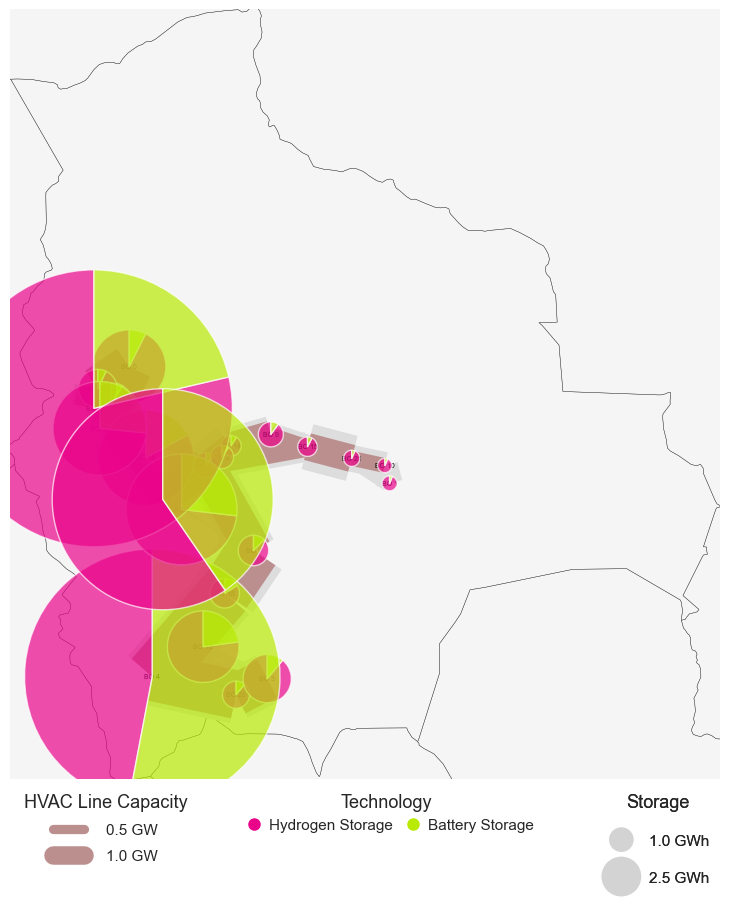

In [158]:
import cartopy.crs as ccrs
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch


def make_handler_map_to_scale_circles_as_in(ax, dont_resize_actively=False):
    fig = ax.get_figure()

    def axes2pt():
        return np.diff(ax.transData.transform([(0, 0), (1, 1)]), axis=0)[0] * (
            300.0 / fig.dpi
        )

    ellipses = []
    if not dont_resize_actively:

        def update_width_height(event):
            dist = axes2pt()
            for e, radius in ellipses:
                e.width, e.height = 2.0 * radius * dist

        fig.canvas.mpl_connect("resize_event", update_width_height)
        ax.callbacks.connect("xlim_changed", update_width_height)
        ax.callbacks.connect("ylim_changed", update_width_height)

    def legend_circle_handler(
        legend, orig_handle, xdescent, ydescent, width, height, fontsize
    ):
        w, h = 2.0 * orig_handle.get_radius() * axes2pt()
        e = Ellipse(
            xy=(0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
            width=w,
            height=w,
        )
        ellipses.append((e, orig_handle.get_radius()))
        return e

    return {Circle: HandlerPatch(patch_func=legend_circle_handler)}


def make_legend_circles_for(sizes, scale=1.0, **kw):
    return [Circle((0, 0), radius=(s / scale) ** 0.5, **kw) for s in sizes]


def add_legend(ax, bus_factor, branch_factor):

    handles = []
    labels = []
    for s in (0.5, 1.0):
        handles.append(
            plt.Line2D([0], [0], color="rosybrown", linewidth=s * 1e3 / branch_factor)
        )
        labels.append(f"{s} GW")
    
    l1 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0, 0),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1.5,
        title="HVAC Line Capacity",
        title_fontsize=13,
        fontsize=11,
    )
    ax.add_artist(l1)

    handles = []
    labels = []
    if "Load" in n.carriers.index:
        n.carriers = n.carriers.drop("Load")

    # Filter n.carriers to only include "H2" and "batteries"
    filtered_carriers = n.carriers.loc[n.carriers.index.isin(['H2', 'battery'])]

    # Iterate over the filtered carriers
    for name, carrier in filtered_carriers.iterrows():
        handles.append(
            plt.Line2D(
                [0], [0], color=carrier.color, marker="o", markersize=8, linewidth=0
            )
        )
        labels.append(carrier.nice_name)
    
    l3 = ax.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.53, -0.0),  # bbox_to_anchor=(0.72, -0.05),
        handletextpad=0.0,
        columnspacing=0.3,
        ncol=2,
        title="Technology",
        title_fontsize=13,
        fontsize=11,
        frameon=False,
    )
    ax.add_artist(l3)

    circles = [10, 25]
    handles = make_legend_circles_for(circles, scale=bus_factor, facecolor="lightgray")
    labels = [f"{float(s/1e1)} GWh" for s in circles]
    l4 = ax.legend(
        handles,
        labels,
        loc="upper left",
        bbox_to_anchor=(0.82, 0.0),
        frameon=False,
        labelspacing=1.5,
        title="Storage",
        title_fontsize=13,
        fontsize=11,
        handler_map=make_handler_map_to_scale_circles_as_in(ax, True),
    )
    ax.add_artist(l4)


def plot_network(n, fn=None):

    bus_factor = 2.0e4
    branch_factor = 7.5e1

    fields = ["bus", "carrier", "e_nom","e_nom_opt"]
        
    pie_components = pd.concat(
        [
            #n.generators[fields],
            #n.storage_units[fields],
            n.stores[fields],
        ]
    )
    # Split the 'Node' index to separate the 'BO' part
    pie_components['bus'] = pie_components["bus"].str.extract(r'(BO \d+)')[0]

    bus_sizes = pie_components.groupby(["bus", "carrier"]).e_nom_opt.sum() / bus_factor

    def clip(df, thres=500):
        return df.where(df > thres, other=0.0)

    line_widths = clip(n.lines.s_nom_opt - n.lines.s_nom) / branch_factor
    link_widths = clip(n.links.p_nom_opt - n.links.p_nom) / branch_factor
    line_widths_opt = n.lines.s_nom_opt / branch_factor

    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw={"projection": ccrs.PlateCarree()}
    )

    n.plot(
        ax=ax,
        bus_sizes=bus_sizes,
        color_geomap=True,
        bus_alpha=0.7,
        line_widths=line_widths_opt,
        line_colors="#dddddd",
    )

    n.plot(
        ax=ax,
        geomap=True,
        bus_sizes=0,
        line_widths=line_widths,
        link_widths=link_widths,
    )


    # Convert "Bus" index column to string type
    filtered_buses = n.buses
    filtered_buses.index = filtered_buses.index.astype(str)
    filtered_buses = n.buses[~n.buses.index.str.contains(r"(H2|battery)$")]
    
    # Add bus names to the plot
    for bus, (lon, lat) in filtered_buses[['x', 'y']].iterrows():
        ax.text(lon, lat, bus, fontsize=5, color='black', ha='center', va='center')


    add_legend(ax, bus_factor, branch_factor)

    ### section added to define the national border
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    shapes=world[world.name.isin(["Bolivia"])].set_index("name")
    ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


    if fn is not None:
        plt.savefig(fn, bbox_inches="tight")


plot_network(n)

In [159]:
#plot_network(n,r"C:\Users\Carlos\Desktop\storage.eps")

In [160]:
bus_factor = 2.0e4
branch_factor = 7.5e1

fields = ["bus", "carrier", "p_nom","p_nom_opt"]
        
pie_components = pd.concat(
        [
            n.generators[fields],
            #n.storage_units[fields],
            #n.stores[fields],
        ]
    )
# Split the 'Node' index to separate the 'BO' part
pie_components['bus'] = pie_components["bus"].str.extract(r'(BO \d+)')[0]

bus_sizes = pie_components.groupby(["bus", "carrier"]).p_nom_opt.sum() / bus_factor
bus_sizes

bus   carrier
BO 0  load       50000.000000
      oil            0.007123
      onwind         0.000011
      solar          0.000096
BO 1  load       50000.000000
                     ...     
BO 8  ror            0.000094
      solar          0.740785
BO 9  load       50000.000000
      onwind         0.000010
      solar          0.000074
Name: p_nom_opt, Length: 80, dtype: float64

In [161]:
bus_factor = 2.0e4
branch_factor = 7.5e1

fields = ["bus", "carrier", "e_nom","e_nom_opt"]
        
pie_components = pd.concat(
        [
            #n.generators[fields],
            #n.storage_units[fields],
            n.stores[fields],
        ]
    )

bus_sizes = pie_components.groupby(["bus", "carrier"]).e_nom_opt.sum() / bus_factor
bus_sizes

bus            carrier
BO 0 H2        H2         0.361608
BO 0 battery   battery    0.028906
BO 1 H2        H2         0.015079
BO 1 battery   battery    0.000976
BO 10 H2       H2         0.013838
BO 10 battery  battery    0.000937
BO 11 H2       H2         0.041350
BO 11 battery  battery    0.005348
BO 12 H2       H2         0.286544
BO 12 battery  battery    0.084922
BO 13 H2       H2         0.118625
BO 13 battery  battery    0.011727
BO 14 H2       H2         0.027144
BO 14 battery  battery    0.002727
BO 15 H2       H2         0.025369
BO 15 battery  battery    0.002053
BO 16 H2       H2         0.548554
BO 16 battery  battery    0.113134
BO 17 H2       H2         0.099618
BO 17 battery  battery    0.007726
BO 18 H2       H2         0.052698
BO 18 battery  battery    0.010144
BO 19 H2       H2         0.466814
BO 19 battery  battery    0.169308
BO 2 H2        H2         0.035203
BO 2 battery   battery    0.003692
BO 20 H2       H2         0.047343
BO 20 battery  battery    0.0059

In [162]:
n.links.p_nom_opt

Link
BO 0 H2 Electrolysis        103.241677
BO 1 H2 Electrolysis          2.621425
BO 10 H2 Electrolysis         2.396762
BO 11 H2 Electrolysis        13.483631
BO 12 H2 Electrolysis       119.430995
                              ...     
BO 5 battery discharger     884.065662
BO 6 battery discharger    4398.278766
BO 7 battery discharger      34.484416
BO 8 battery discharger    5259.565687
BO 9 battery discharger      20.218199
Name: p_nom_opt, Length: 88, dtype: float64

In [163]:
n.stores.e_nom_opt

Store
BO 0 H2           7232.168735
BO 1 H2            301.580038
BO 10 H2           276.767322
BO 11 H2           826.997872
BO 12 H2          5730.871292
BO 13 H2          2372.505102
BO 14 H2           542.882441
BO 15 H2           507.379152
BO 16 H2         10971.078551
BO 17 H2          1992.368294
BO 18 H2          1053.956459
BO 19 H2          9336.289215
BO 2 H2            704.050895
BO 20 H2           946.850202
BO 21 H2           352.841495
BO 3 H2           2995.189267
BO 4 H2          44468.545923
BO 5 H2          13020.519638
BO 6 H2          87420.182434
BO 7 H2           1173.681613
BO 8 H2          42198.825650
BO 9 H2            816.453426
BO 0 battery       578.118998
BO 1 battery        19.511063
BO 10 battery       18.730966
BO 11 battery      106.963389
BO 12 battery     1698.434291
BO 13 battery      234.543081
BO 14 battery       54.549797
BO 15 battery       41.066296
BO 16 battery     2262.689894
BO 17 battery      154.510083
BO 18 battery      202.876344
BO 1

In [164]:
n.stores.e_nom_opt.sum()

352116.50719620957

In [165]:
n.storage_units

,bus,p_min_pu,cyclic_state_of_charge,carrier,efficiency_dispatch,efficiency_store,p_nom,max_hours,marginal_cost,build_year,p_nom_opt,control,type,p_nom_extendable,p_nom_min,p_nom_max,p_max_pu,p_set,q_set,sign,marginal_cost_quadratic,capital_cost,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge_per_period,standing_loss,inflow
StorageUnit,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 11 hydro,BO 11,0.0,True,hydro,0.9,0.0,118.68,1300.0,0.010015,0,118.68,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
BO 13 hydro,BO 13,0.0,True,hydro,0.9,0.0,38.40,1300.0,0.010627,0,38.40,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
BO 14 hydro,BO 14,0.0,True,hydro,0.9,0.0,156.36,1300.0,0.010957,0,156.36,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
BO 17 hydro,BO 17,0.0,True,hydro,0.9,0.0,27.66,1300.0,0.010974,0,27.66,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
BO 3 hydro,BO 3,0.0,True,hydro,0.9,0.0,7.46,1300.0,0.009960,0,7.46,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
BO 8 hydro,BO 8,0.0,True,hydro,0.9,0.0,6.13,1300.0,0.009253,0,6.13,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,0.0,0.0,inf,0.0,False,NaN,True,0.0,0.0
